<a href="https://colab.research.google.com/github/r0c10/Python_project/blob/master/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parte 1: Entrenamiento, selección y validación

In [91]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Engineering

In [92]:
from google.colab import files
uploaded = files.upload()

In [93]:
df_titanic = pd.read_csv('data_titanic_proyecto.csv')
df_titanic.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [94]:
full_data = [df_titanic]

# Feature that tells whether a passenger had a cabin on the Titanic
df_titanic['Has_Cabin'] = df_titanic["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(df_titanic['Fare'].median())
df_titanic['CategoricalFare'] = pd.qcut(df_titanic['Fare'], 4,duplicates='drop')
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
df_titanic['CategoricalAge'] = pd.cut(df_titanic['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['passenger_sex'] = dataset['passenger_sex'].map( {'F': 0, 'M': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    # Mapping passenger_class
    dataset['passenger_class'] = dataset['passenger_class'].map( {'Lower': 1, 'Middle': 2, 'Upper': 3} ).astype(int)
    # Mapping passenger_survived
    dataset['passenger_survived'] = dataset['passenger_survived'].map( {'Y': 1, 'N': 0} ).astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
# Feature selection
data_titanic = df_titanic.drop(['Name', 'Ticket', 'Cabin','CategoricalAge', 'CategoricalFare'], axis=1)

In [ ]:
data_titanic.head(3)

,PassengerId,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived,Has_Cabin,FamilySize,IsAlone,Title
0,1,1,1,0,0,0,1,1,0,0,2,0,0
1,2,2,1,0,3,1,3,0,1,1,2,0,2
2,3,1,0,0,1,0,1,0,1,0,1,1,1


#### Correlation

#### TRAIN, VALIDATION AND TEST SET:

In [96]:
train, test = train_test_split(data_titanic, test_size = 0.20)
print(train.shape)
print(test.shape)

(712, 13)
(179, 13)


In [100]:
PassengerId = test['PassengerId']
PassengerId.to_csv("PassengerId.csv",index=False)

In [ ]:
train = train.drop(['PassengerId'], axis=1)
test = test.drop(['PassengerId'], axis=1)
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)

In [ ]:
train.head(3)
test.head(3)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived,Has_Cabin,FamilySize,IsAlone,Title
386,0,5,2,3,0,1,1,0,0,8,0,3
351,1,0,0,3,0,3,1,0,1,1,1,0
681,1,0,0,3,1,3,1,1,1,1,1,0


Our dataset is now much cleaner than before, with only numerical values and potentially meaningful features. Let's now explore the relationship between our variables by plotting the Pearson Correlation between all the attributes in our dataset (credit to Anisotropic for this beautiful plot):

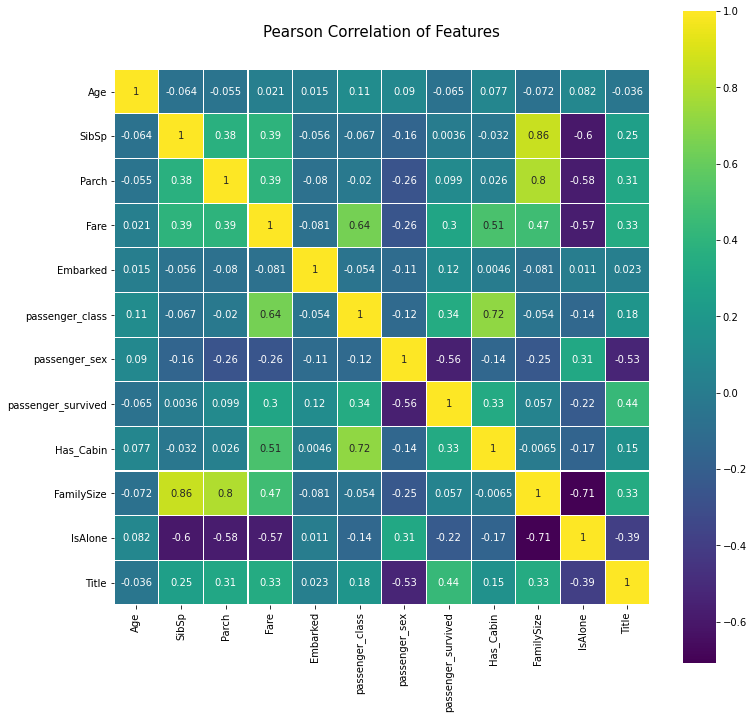

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

This heatmap is very useful as an initial observation because you can easily get an idea of the predictive value of each feature. In this case, Sex and Title show the highest correlations (in absolute terms) with the class (Survived): 0.54 and 0.49 respectively. But the absolute correlation between both is also very high (0.86, the highest in our dataset), so they are probably carrying the same information and using the two as inputs for the same model wouldn't be a good idea. High chances are one of them will be used for the first node in our final decision tree, so let's first explore further these features and compare them.

In [ ]:
#Split data into training and validation set
X = train.drop(columns=['passenger_survived'], axis=1)
y = train['passenger_survived']

#Note they are labeled as test sets but I'm treating them as validation data sets.
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

X_test = test.drop(columns=['passenger_survived'], axis=1)
print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (569, 11)
Train labels shape:  (569,)
Validation data shape:  (143, 11)
Validation labels shape:  (143,)
Test data shape:  (179, 11)


In [ ]:
# Guardando train, val and test values
x_train.to_csv("x_train.csv",index=False)
y_train.to_csv("y_train.csv",index=False)
x_val.to_csv("x_val.csv",index=False)
y_val.to_csv("y_val.csv",index=False)
X_test.to_csv("X_test.csv",index=False)

## Modelos
### Desicion Tree

I will do this for each model listed above. The dataframe below will hold the validation results.

In [ ]:
results = pd.DataFrame(columns=['Validation'], index=['Decision Tree', 'Support Vector Machine', 'Naive Bayes', 'Logistic Regression'])

Finding best tree depth with the help of Cross Validation

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.iloc[train_fold] # Extract train data with cv indices
        f_valid = train.iloc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['passenger_survived'], axis=1), 
                               y = f_train['passenger_survived']) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['passenger_survived'], axis=1), 
                                y = f_valid['passenger_survived'])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.793427
         2          0.787774
         3          0.827230
         4          0.834272
         5          0.825841
         6          0.817351
         7          0.808998
         8          0.803384
         9          0.801956
        10          0.793486
        11          0.786444
        12          0.786463


The best max_depth parameter seems therefore to be 3 (82.7% average accuracy across the 12 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 5 as the max_depth parameter for our final model.

In [ ]:
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

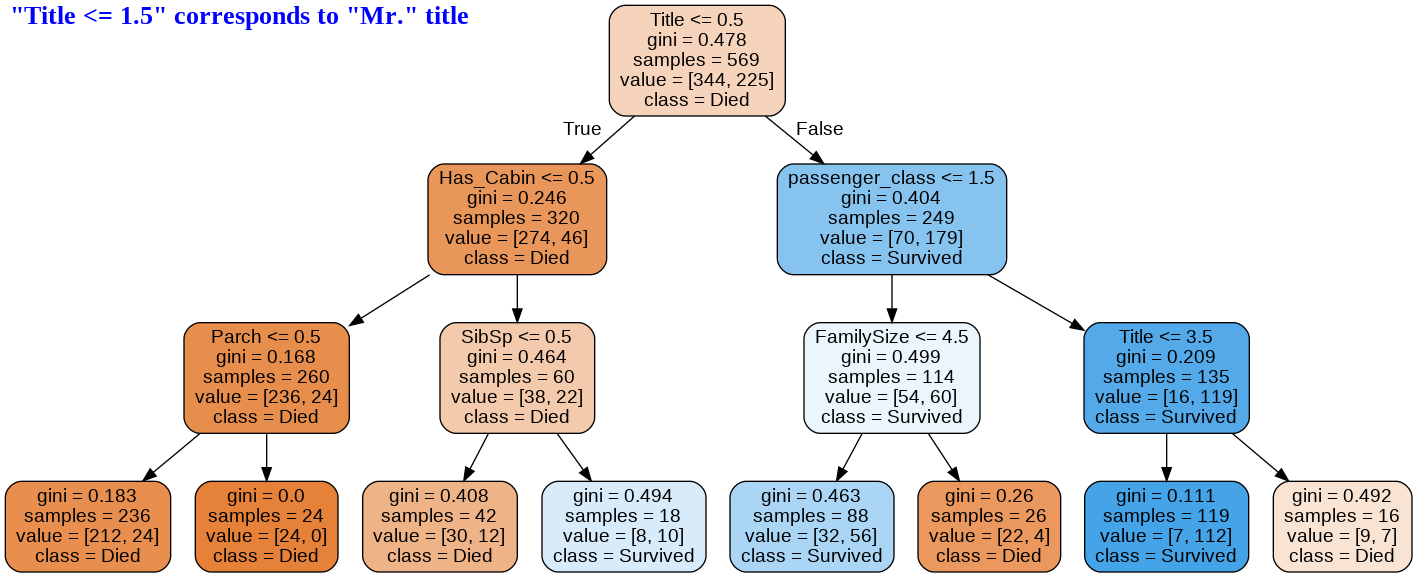

In [ ]:
# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_val)


# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 5,
                              impurity = True,
                              feature_names = list(train.drop(['passenger_survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [ ]:
# Accuracy
accuracy_dt = decision_tree.score(x_val, y_val)

#Add to dataframe.
results.loc['Decision Tree', 'Validation'] = accuracy_dt
results

,Validation
Decision Tree,0.846154
Support Vector Machine,NaN
Naive Bayes,NaN
Logistic Regression,NaN


### SVM

In [ ]:
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 

In [ ]:
def svm(X_train, X_test, y_train, y_test):
    
    #Scale data
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)
    
    #Create list of c values to try
    c_vals = list(range(1, 100))
    
    #Accuracy list
    accuracy = [0 for i in range(99)]
    
    #Loop through c_values
    for i, c in enumerate(c_vals):
        #Create support vector machine object
        svc_model = SVC(C=c)
        
        #fit support vector machine model
        svc_model.fit(X_train, y_train)
        
        #Make predictions
        predictions = svc_model.predict(X_test)
        
        #add accuracy score to accuracy list
        accuracy[i] = accuracy_score(y_test, predictions)
    
    print("Best C Value:", c_vals[accuracy.index(max(accuracy))])
    print(accuracy)
    print("Prediction Accuracy: ", max(accuracy))
    
    return max(accuracy),predictions

In [ ]:
#Get support vector machine results
svm_acc,svm_preds = svm(x_train, x_val, y_train, y_val)

#Add to dataframe.
results.loc['Support Vector Machine', 'Validation'] = svm_acc
results.head()

Best C Value: 18
[0.8251748251748252, 0.8251748251748252, 0.8251748251748252, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8111888111888111, 0.8181818181818182, 0.8181818181818182, 0.8181818181818182, 0.8111888111888111, 0.8111888111888111, 0.8251748251748252, 0.8251748251748252, 0.8251748251748252, 0.8251748251748252, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8321678321678322, 0.8251748251748252, 0.8251748251748252, 0.

,Validation
Decision Tree,0.846154
Support Vector Machine,0.832168
Naive Bayes,NaN
Logistic Regression,NaN


In [ ]:
#exportando svm del modelo final
import joblib
joblib.dump(svm, 'svm.joblib')

['svm.joblib']

### Naive Bayes

In [ ]:
from sklearn.metrics import confusion_matrix as confussionMatrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import pandas as pd

In [ ]:
classes = y_train.unique()

#calcular medias,varianzas y prior para cada clase
means = []
variances = []
priors = []
for c in classes:
    f = x_train[np.array(y_train)==c]
    mean = f.mean()
    var = f.var()
    prior = f.shape[0]/len(x_train)
    means.append(np.array(mean))
    variances.append(np.array(var))
    priors.append(np.array(prior))

#Calculo de probabilidades condicionales

def getValueProb(c, x):
        mean = means[c]
        var = variances[c]
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

def getPosteriors(x):
    posts = []
    for i,c in enumerate(classes):
        prior = np.log(priors[i])#obtenemos la probabilidad de la clase
        post = np.sum(np.log(getValueProb(i,x)))
        post = post + prior
        posts.append(post)
    return classes[np.argmax(posts)]#retornamos la probabilidad mayor

def nb_predict(X_test):
        y_pred_test = [getPosteriors(x) for x in np.array(X_test)]
        return y_pred_test

# modelo
nb_preds = nb_predict(x_val)#entrenando el modelo


In [ ]:
# Accuracy
acc_nb = accuracy_score(y_val, nb_preds)
#Add to dataframe.
results.loc['Naive Bayes', 'Validation'] = acc_nb
results.head()

,Validation
Decision Tree,0.846154
Support Vector Machine,0.832168
Naive Bayes,0.804196
Logistic Regression,NaN


In [ ]:
#exportando svm del modelo final
joblib.dump(nb, 'nb.joblib')

['nb.joblib']

### Logistic Regression

In [63]:
import math
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [ ]:
X_train = x_train.values
X_val = x_val.values
Y_train = y_train.values
Y_val = y_val.values

X_Test = X_test.values

In [ ]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [cost_op,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in np.arange(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in np.arange(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {x: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"
              .format(total_loss,total_correct,e+1))
        if plot_losses and (e == epochs-1):
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

Here the number of features = 10

And the number of classes/Labels we are predicting (here just 2: survived or not_survived)

In [ ]:
numFeatures = X_train.shape[1]
numLabels = 2

#### CREATING PLACEHOLDERS AND INITIALIZATIONS:

* Placeholders: Here we need two placeholders for input X and output y respectively. A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later.

* Lambda: Regularization Parameter. Avoids overfitting. Start with 0.001 value and increase or decrease it accordingly.

* Learning Rate: In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function.

In [ ]:
# clear old variables
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, numFeatures])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
Lambda = 0.001 #Regularization Parameter
learningRate = tf.train.exponential_decay(learning_rate=1e-2,
                                          global_step= 1,
                                          decay_steps=X_train.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

LOGISTIC REGRESSION MODEL:

This model uses Sigmoid as the activation function. L2 Regularization is used.

fully_connected_layer = x*weights + bias

activation_layer = sigmoid(fully_connected_layer)

Loss = cross_entropy(activation_layer)+Lambda*L2_loss

Using GradientDescent Optimizer

In [ ]:
# Logistic Regression
def lr_model(x,y,is_training): 
    weights=tf.get_variable("weights",shape=[numFeatures,numLabels])
    bias=tf.get_variable("bias",shape=[numLabels])
    y_out = tf.matmul(x,weights)+bias
    return (y_out,weights)

y_out,weights = lr_model(x,y,is_training)

In [ ]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.one_hot(y,2),logits=y_out))
regularizer = tf.nn.l2_loss(weights)
cost_op = tf.reduce_mean(loss + Lambda * regularizer)
optimizer = tf.train.GradientDescentOptimizer(learningRate)
train_step = optimizer.minimize(cost_op)

In [ ]:
#Prediction
prediction = tf.argmax(y_out,1)

In [ ]:
# Strating a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

TRAINING & VALIDATION

Parameters:

 session, predict, loss_val, Xd, yd,epochs, batch_size, print_every,training, plot_losses

 Here I am using epochs = 100, batch_size = 100, print_every = 100.

 Tune this accordingly to get best results.

Training
Iteration 0: with minibatch training loss = 0.491 and accuracy of 0.8
Epoch 1, Overall loss = 0.451 and accuracy of 0.814
Epoch 2, Overall loss = 0.451 and accuracy of 0.814
Epoch 3, Overall loss = 0.451 and accuracy of 0.814
Epoch 4, Overall loss = 0.451 and accuracy of 0.814
Epoch 5, Overall loss = 0.451 and accuracy of 0.814
Epoch 6, Overall loss = 0.451 and accuracy of 0.814
Epoch 7, Overall loss = 0.451 and accuracy of 0.814
Epoch 8, Overall loss = 0.451 and accuracy of 0.814
Epoch 9, Overall loss = 0.451 and accuracy of 0.814
Epoch 10, Overall loss = 0.451 and accuracy of 0.814
Epoch 11, Overall loss = 0.451 and accuracy of 0.814
Epoch 12, Overall loss = 0.451 and accuracy of 0.814
Epoch 13, Overall loss = 0.451 and accuracy of 0.814
Epoch 14, Overall loss = 0.451 and accuracy of 0.814
Epoch 15, Overall loss = 0.451 and accuracy of 0.814
Epoch 16, Overall loss = 0.451 and accuracy of 0.814
Iteration 100: with minibatch training loss = 0.376 and accuracy of 0.85
Epoch 17,

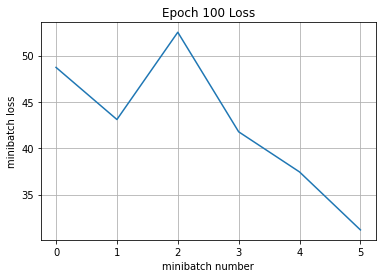

Validation
Epoch 1, Overall loss = 0.464 and accuracy of 0.818


In [ ]:
print('Training')
run_model(sess,y_out,cost_op,X_train,Y_train,100,100,100,train_step,True)
print('Validation')
loss_lr, accuracy_lr = run_model(sess,y_out,cost_op,X_val,Y_val,1,100)

RECEIVER OPERATING CHARACTERISTIC(ROC) CURVE:

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

This can be used to analyse if the classifier is skewed or not. (i.e) To make sure that the classifier doesn't always predict the same output

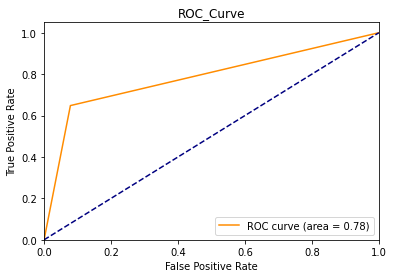

In [ ]:
predicted_vallabels = np.zeros(X_val.shape[0])
for i in np.arange(0,X_val.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_vallabels[start:end] = sess.run(prediction,feed_dict={x: X_val[start:end,:],y: predicted_vallabels[start:end],is_training: False})
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = metrics.roc_curve(Y_val, predicted_vallabels)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_Curve')
plt.legend(loc="lower right")
plt.show()

In [65]:
def get_session(sess):
    session = sess
    while type(session).__name__ != 'Session':
        #pylint: disable=W0212
        session = session._sess
    return session

In [66]:
saver = tf.train.Saver()
saver.save(get_session(sess), 'lr_model',global_step=1001) #guardando modelo

'lr_model-1001'

In [ ]:
#Add to dataframe.
results.loc['Logistic Regression', 'Validation'] = accuracy_lr
results.to_csv("validations_results.csv",index=False)
results.head()

,Validation
Decision Tree,0.846154
Support Vector Machine,0.832168
Naive Bayes,0.804196
Logistic Regression,0.818182


Según la tabla anterior, se puede concluir que el mejor modelo para predecir la data es Decision Tree

## K-fold cross validation (sklearn)

In [67]:
from collections import Counter

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [68]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=4)

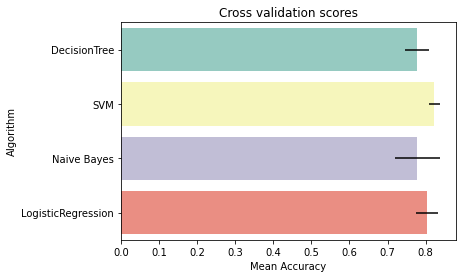

In [69]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree", "SVM","Naive Bayes","LogisticRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [70]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.778588,0.031465,DecisionTree
1,0.822491,0.014458,SVM
2,0.778674,0.058668,Naive Bayes
3,0.803211,0.028223,LogisticRegression


Al comparar la tabla anterior con este gráfico y observar los valores de precisión para la primera práctica, se tiene que:

Decision Tree > SVM > Regresión Logística > Naive Bayes

Mientras que cuando se implementa el k-fold Cross Validation se obtiene:

SVM > Regresión Logística > Naive Bayes > Decision Tree 
 
Los únicos que alcanzan valores por encima del 80% de precisión son SVM y regresión logística (0.82 y 0.80 respectivamente).

* Conclusión de utilizar esta técnica:  
 La técnica del k-fold Cross Validation es una de las maneras más convenientes de seleccionar un modelo de aprendizaje automático frente a un problema o un conjunto de datos en particular. Ya que la Validación Cruzada aplica de manera iterativa cada modelo sobre todo el conjunto de entrenamiento tomando diversas (k) particiones, podemos afirmar que el resultado en promedio nos da una idea precisa de cuál es el desempeño del modelo de clasificación sobre el conjunto de datos entero, de modo que podemos caracterizar de manera adecuada cada algoritmo.  
Sin embargo, aunado a la Validación Cruzada, a fin de mejorar todavía más el desempeño de los modelos sería necesario como siguiente paso hacer una afinación de los hiper parámetros de los modelos, es decir, todos esos parámetros que no se modifican durante la fase de entrenamiento, sino que son variables ajustables de cada modelo (como el valor de k en k-NN, el valor de C en las SVM, o la cantidad de árboles en el Random Forest, por mencionar algunos) y que, sin duda, van a afectar la calidad de cada uno de ellos.  
Al final, la selección del mejor modelo para un problema dado dependerá no solo del resultado de la Validación Cruzada, sino de cuánto más se pueden afinar los parámetros de los modelos a fin de obtener resultados con alta precisión y poco error, además de baja variancia y bajo bias, es decir, modelos adecuados que no estén ni sub-entrenados ni sobre-entrenados.

## Prueba/ Evaluación final

In [80]:
#Get prediction of models.
# Decision tree
pred_dt_ = decision_tree.predict(X_test)
#SVM
svm_acc_,svm_preds_ = svm(x_train, X_test, y_train, test['passenger_survived'])
# Naive Bayes
nb_preds_ = nb_predict(X_test)
# Logistic regression
predicted_labels = np.zeros(X_Test.shape[0])
for i in np.arange(0,X_test.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_labels[start:end] = sess.run(prediction,feed_dict={x: X_Test[start:end,:],y: predicted_labels[start:end],is_training: False})

Best C Value: 70
[0.7988826815642458, 0.7988826815642458, 0.7988826815642458, 0.7932960893854749, 0.7932960893854749, 0.8044692737430168, 0.8044692737430168, 0.7932960893854749, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.8044692737430168, 0.

In [81]:
# Accuracy
from sklearn.metrics import accuracy_score

y_true = test['passenger_survived']
acc_dt = accuracy_score(y_true, pred_dt_)
acc_nb_ = accuracy_score(y_true, nb_preds_)
acc_lr = accuracy_score(y_true, predicted_labels)

acc_all = pd.DataFrame(columns=['Validation'], index=['Decision Tree', 'Support Vector Machine', 'Naive Bayes', 'Logistic Regression'])
acc_all.loc['Decision Tree', 'Validation'] = acc_dt
acc_all.loc['Support Vector Machine', 'Validation'] = svm_acc_
acc_all.loc['Naive Bayes', 'Validation'] = acc_nb_
acc_all.loc['Logistic Regression', 'Validation'] = acc_lr
acc_all.head()

,Validation
Decision Tree,0.798883
Support Vector Machine,0.810056
Naive Bayes,0.765363
Logistic Regression,0.810056


Los valores obtenidos en esta tabla final, coinciden con los obtenidos en el K-fold cross validation, donde se obtiene que los modelos que mejor predicen son SVM y regresión logística

In [121]:
all_preds = {'Survived': y_true,'DT': pred_dt_, 'SVM': svm_preds_, 'NB': nb_preds_,'LR': predicted_labels}
predictions_all = pd.DataFrame(data = all_preds)
predictions_all

,Survived,DT,SVM,NB,LR
386,0,0,0,0,0.0
351,0,0,0,1,0.0
681,1,0,0,1,0.0
804,1,0,0,0,0.0
695,0,0,0,0,0.0
...,...,...,...,...,...
881,0,0,0,0,0.0
809,1,1,1,1,1.0
110,0,0,0,1,0.0
342,0,0,0,0,0.0


In [122]:
# Guardando predicciones
predictions_all.to_csv("final_preds.csv",index=False)

Combinando resultado de predicciones

In [79]:
preds_all = ((pred_dt_+svm_preds_+predicted_labels)/3).astype(int)
#accuracy
accuracy_score(y_true, preds_all)

0.8100558659217877

Se obtiene la misma exactitud que si se utilizara SVM o regresión logística solos

## Conclusiones
Los modelos qu emejor predicen son SVM y regresión logística.

* Modelo árbol de decisión
Se usó el paquete scikit-learn tree, DecisionTreeClassifier, para realizar el árbol de desición, investigando los parametros que recibe la función, se experimento con diferentes de estos para obtener el mejor modelo según las métricas de nuestro interés.

* Modelo SVM.
Se usó el paquete de scikit-learn svm, y su función de entranimiento fit, también se realizo la busqueda de los mejores hyperparametros para la función, evaluando las métricas de interés.

* Modelo Naive Bayes
Se implementó el modelo con numpy y pandas; se realizó un modelo utilizando estimación de verosimilitud para el cálculo de probabilidades condicionales, estimando medias y variancias de las clases.


* Modelo Regresión Logistica
Se implementó el modelo utilizando L2 loss con tensorflow, con las funciones sigomoid o softmax para el entrenamiento del modelo.


## Deployment, Evaluación y prueba final.
Utilizando el dataset de pruebas se realizó la evaluación final de los modelos, según nuestras metricas de interés se cumplió con el objetivo. Los modelos entrenados cumplen con las espectativas y son capaces de realizar predicciones acertadas en su mayoría.

Para la elección y decisión del valor a predecir, se realizo la técnica de k-fold cross validation de los 4 modelos, utilizando scikit-learn.


## Experiencias y Aprendizaje.
 
Exportar modelos con tensorflow  
Exportar modelos de scikit-learn  
Algoritmo de naive bayes  
Experimentación de modelos y elección de los mejores hyperparametros   

## Recomendaciones
Analizar, limpiar y transormar los datos, aunque sea lo que más tiempo conlleva es lo más importante para construir modelos y que estos sean de calidad.
Experimentar y evaluar los modelos con diferentes hyperparametros, evaluando las metricas de interés, es uno de los pasos más importantes para la creación de un algoritmo de machine learning.
Utilizar técnicas de validación para mejorar el modelo.